https://www.kaggle.com/bimimi/udacity-online-product-a-b-test

# Import Module

In [61]:
import numpy as np
import pandas as pd
import math as mt
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os
print(os.listdir('../data/udacity'))
warnings.filterwarnings('ignore')

['control_data.csv', 'experiment_data.csv']


# Load Dataset

In [33]:
exp_data = pd.read_csv('../data/udacity/experiment_data.csv')
ctrl_data = pd.read_csv('../data/udacity/control_data.csv')

## Describe Data
- Pageviews: 해당 날짜에 강좌 소개를 본 고유 쿠키 수
- Clicks: 해당 날짜에 강좌 소개 페이지에서 클릭이 발생한 고유 쿠키 수
- Enrollments: 해당 날짜에 14일 무료 체험에 등록한 사용자 ID 수
- Payments: 14일 무료 체험 후, 결제까지 한 사용자 ID 수


- 결제는 무료 체험이 끝난 이후에 발생하기 때문에, 가장 최근 14일에 대한 Enrollments와 Payments는 결측값

# Exploatory Data Analysis

## Control Data
- 관측 기간: 10월 11일 (토) ~ 11월 16일 (일), 37일

In [34]:
print("Control Data Shape: ", ctrl_data.shape)
ctrl_data.head()

Control Data Shape:  (37, 5)


,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


### Check Null Value

In [35]:
def CheckNull(data):
    cols = data.columns
    
    for col in cols:
        if data[col].isnull().any():
            print("[{}] Column has Null Value".format(col))
            
        else:
            pass

In [36]:
CheckNull(ctrl_data)

[Enrollments] Column has Null Value
[Payments] Column has Null Value


In [37]:
ctrl_data.loc[(ctrl_data['Enrollments'].isnull()) & (ctrl_data['Payments'].isnull())]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9437,788,NaN,NaN
24,"Tue, Nov 4",9420,781,NaN,NaN
25,"Wed, Nov 5",9570,805,NaN,NaN
26,"Thu, Nov 6",9921,830,NaN,NaN
27,"Fri, Nov 7",9424,781,NaN,NaN
28,"Sat, Nov 8",9010,756,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN
30,"Mon, Nov 10",10419,874,NaN,NaN
31,"Tue, Nov 11",9880,830,NaN,NaN
32,"Wed, Nov 12",10134,801,NaN,NaN


## Experiment Data
- 관측 기간: 10월 11일 (토) ~ 11월 16일 (일), 37일
- 사용자가 무료 체험을 클릭하면 얼마를 사용할 수 있는지 나타내는 프롬프트가 표시
- 5시간/주 이상이라면, 무료 체험 시작
- 5시간/주 미만이라면, 더 많은 시간을 요구하는 메시지 팝업

<b>Units</b>
- 전환 단위 = Cookie
- 무료 체험판에 등록된 사용자를 ID로 추적
- 동일한 사용자 ID로 무료 체험판을 중복 등록할 수 없음

<b>Tracking Method</b>
- Pre-Enrollment = Cookies
- Post-Enrollment = User-id
- Non-Enrolled = Not Tracked

In [18]:
print("Experiment Data Shape: ", exp_data.shape)
exp_data.head()

Experiment Data Shape:  (37, 6)


,Date,Pageviews,Clicks,Enrollments,Payments,type
0,"Sat, Oct 11",7716,686,105.0,34.0,experiment
1,"Sun, Oct 12",9288,785,116.0,91.0,experiment
2,"Mon, Oct 13",10480,884,145.0,79.0,experiment
3,"Tue, Oct 14",9867,827,138.0,92.0,experiment
4,"Wed, Oct 15",9793,832,140.0,94.0,experiment


In [38]:
CheckNull(exp_data)

[Enrollments] Column has Null Value
[Payments] Column has Null Value


In [40]:
exp_data.loc[(exp_data['Enrollments'].isnull()) & (exp_data['Payments'].isnull())]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9359,789,NaN,NaN
24,"Tue, Nov 4",9427,743,NaN,NaN
25,"Wed, Nov 5",9633,808,NaN,NaN
26,"Thu, Nov 6",9842,831,NaN,NaN
27,"Fri, Nov 7",9272,767,NaN,NaN
28,"Sat, Nov 8",8969,760,NaN,NaN
29,"Sun, Nov 9",9697,850,NaN,NaN
30,"Mon, Nov 10",10445,851,NaN,NaN
31,"Tue, Nov 11",9931,831,NaN,NaN
32,"Wed, Nov 12",10042,802,NaN,NaN


## Merge Dataset by Type

In [43]:
ctrl_data['type'] = "control"
exp_data['type'] = "experiment"

data = pd.concat([ctrl_data, exp_data], axis = 0).reset_index(drop = True)
data.head()

,Date,Pageviews,Clicks,Enrollments,Payments,type
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control


## PageView

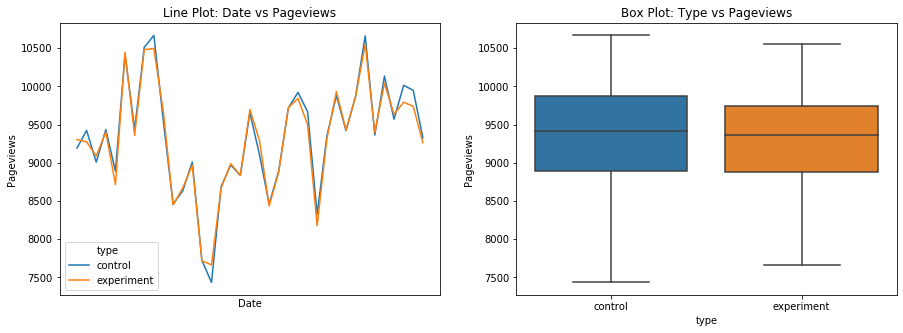

In [57]:
f = plt.figure(figsize = (15, 5))
f.add_subplot(1, 2, 1)
sns.lineplot(x = 'Date', y = 'Pageviews', hue = 'type', data = data)
plt.title("Line Plot: Date vs Pageviews")
plt.xticks([])

f.add_subplot(1, 2, 2)
sns.boxplot(x = 'type', y = 'Pageviews', data = data)
plt.title("Box Plot: Type vs Pageviews")
plt.show()

## Clicks

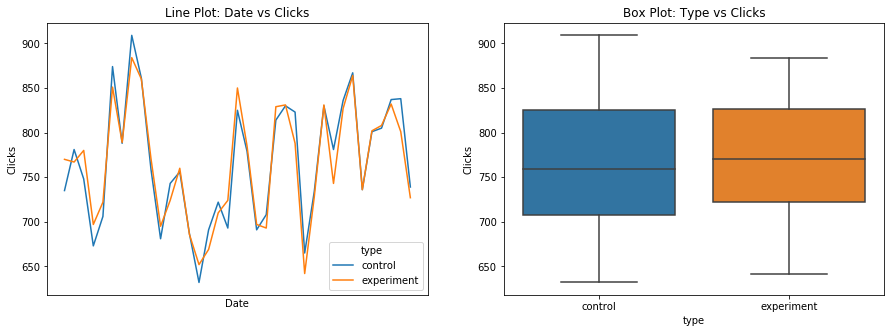

In [58]:
f = plt.figure(figsize = (15, 5))
f.add_subplot(1, 2, 1)
sns.lineplot(x = 'Date', y = 'Clicks', hue = 'type', data = data)
plt.title("Line Plot: Date vs Clicks")
plt.xticks([])

f.add_subplot(1, 2, 2)
sns.boxplot(x = 'type', y = 'Clicks', data = data)
plt.title("Box Plot: Type vs Clicks")
plt.show()

## Enrollments

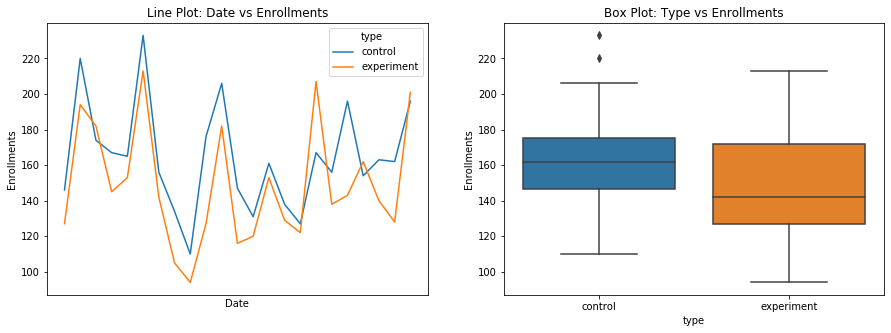

In [59]:
f = plt.figure(figsize = (15, 5))
f.add_subplot(1, 2, 1)
sns.lineplot(x = 'Date', y = 'Enrollments', hue = 'type', data = data)
plt.title("Line Plot: Date vs Enrollments")
plt.xticks([])

f.add_subplot(1, 2, 2)
sns.boxplot(x = 'type', y = 'Enrollments', data = data)
plt.title("Box Plot: Type vs Enrollments")
plt.show()

## Payments

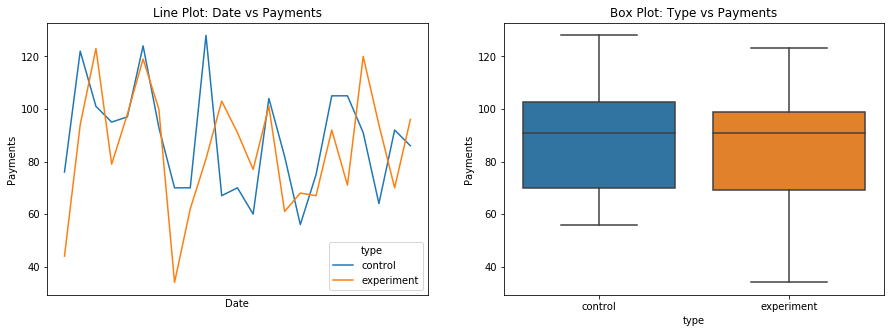

In [60]:
f = plt.figure(figsize = (15, 5))
f.add_subplot(1, 2, 1)
sns.lineplot(x = 'Date', y = 'Payments', hue = 'type', data = data)
plt.title("Line Plot: Date vs Payments")
plt.xticks([])

f.add_subplot(1, 2, 2)
sns.boxplot(x = 'type', y = 'Payments', data = data)
plt.title("Box Plot: Type vs Payments")
plt.show()

# Practice A/B Test

## Hypothesis
1) 명확한 기대치를 미리 설정하게 되면, 무료 체험판에 실망한 유저가 줄어든다.

2) 무료 평가판 및 강좌의 최종 수강 완료까지 사용자 수가 크게 감소하지 않는다.

3) 사용자 경험의 전반적인 개선

## Metric Choice
- Invar Metric + Evaluation Metric

### Invar Metric
- 실험으로 인해 영향을 받지 않아야 하며, Control Group과 Experiment Group간 크게 변하지 않아야 한다.

- Metric Name: Number of Cookies in Course Overview Page (강좌 개요 페이지의 쿠키 수)
    - Metric Formula: # unique daily cookies on page (페이지의 일별 고유 쿠키 수)
    - Dmin: 3,000 (Cookies)
    - Notation: $C_k$
    

- Metric Name: Number of Clicks on Free Trial Button (무료 체험 버튼을 클릭한 횟수)
    - Metric Formula: # unique daily cookies who clicked (클릭한 일별 고유 쿠키 수)
    - Dmin: 240 (Clicks)
    - Notation: $C_l$
    
- Metric Name: Free Trial Button Click-Through-Probability (무료 체험 버튼 클릭 확률)
    - Metric Formula: $C_k / C_l$
    - Dmin: 0.01
    - Notation: $CTP$
    
    
### Invar Metrics Explained
<b> Number of Cookies</b>
- 강좌 개요를 본 고유 쿠키 수

<b> Number of Clicks</b>
- 무료 체험 버튼을 클릭한 쿠키의 수

<b>Click through Probability</b>
- Number of Clicks / Number of Cookies

### Eval Metrics
- Evaluation: 비즈니스 목표와 관련된 변경 예상 평가 척도
- 각 평가 척도는 사용자 잔존률과 같은 비즈니스에 중요한 최소 변경 사항을 $Dmin$으로 표시한다.
- 통계적으로 유의할 수 있는 것은 비즈니스 목표에 실질적으로 유의하지 않을 수 있다.

- Gross Conversion: $\frac{\ enrolled }{\ C_l}$ = $Conversion_{Gross}$
    - $Dmin$ = 0.01